Sources used for Part 2:

The textbook: https://d2l.ai/chapter_convolutional-modern/resnet.html

This post: https://hd10.dev/posts/experiments_cifar10_part1/

Blog series linked: https://myrtle.ai/learn/how-to-train-your-resnet/

Pytorch tutorial: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb#scrollTo=Kzv0l9IReJ_A

Resent implementation: https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/

# 1. Receptive field and parameter count (1 point)

Recall that the *receptive field* refers to size of the region in the input that are visible to a given activation (or neuron) in a convolutional neural network. "Visible" here means that the values of those inputs affect the value of the activation. In all of the following questions, assume that the input image is arbitrarily large, so you don't need to worry about boundary effects or padding.

1. Consider a convolutional network which consists of three convolutional layers, each with a filter size of 3x3, and a stride of 1x1. What is the receptive field size of one of the activations at the final output?
1. What is the receptive field if the stride is 2x3 at each layer?
1. What is the receptive field if the stride is 2x2 at each layer, and there is a 2x2 max-pooling layer with stride 2x2 after each convolutional layer?
1. Assume that the input image has 3 channels, the three convolutional layers have 16, 32, and 64 channels respectively, and that there are no biases on any of the layers. How many parameters does the network have?

**Answer**
1. The size of the receptive field here is 7x7 (49).
2. Receptive field is 15x27 (405)
3. Receptive field is 85x85 (7225)
4. Total parameters is (3x3x3x16)+(3x3x16x32)+(3x3x32x64)=23,472.


For the first three questions, I drew it out to gain an intuition and come to an answer for the receptive fields.

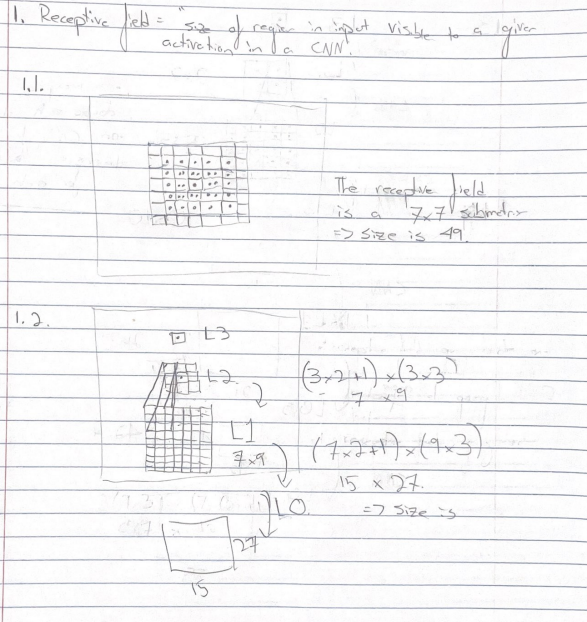

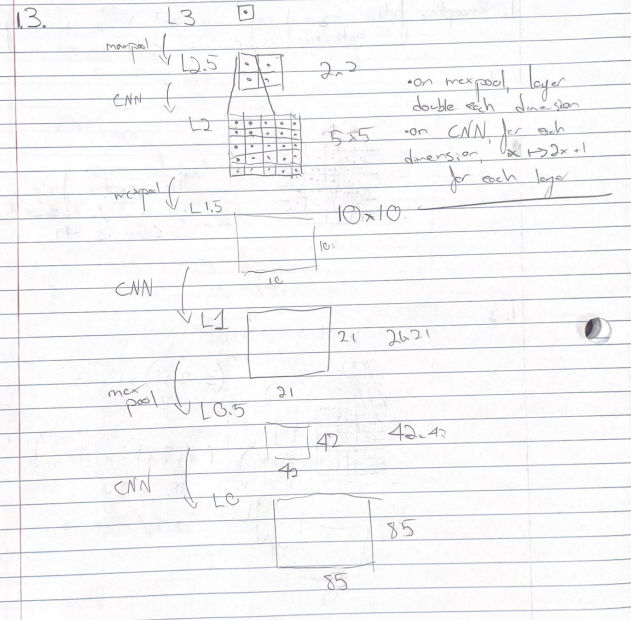

# 2. CIFAR-10 classification (4 points)

CIFAR-10 is a standard dataset where the goal is to classify 32 x 32 images into one of 10 classes. The goal of this problem is simple: build and train a convolutional neural network to perform classification on CIFAR-10. The problem is intentionally extremely open-ended! There are dozens (hundreds?) of tutorials online describing how to train a convnet on CIFAR-10 - please seek them out and make use of them. I recommend getting started with the [CIFAR-10 tutorial from PyTorch](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb) which includes code for loading the dataset and evaluating performance on it. You are welcome to use any other resource that you want (but please cite it!) - as I mentioned there are many, many tutorials online, and googling for help is an utterly crucial skill for a researcher! You will be graded on the final test accuracy achieved by your model:

- 60% accuracy or higher: 2/4 points
- 75% accuracy or higher: 3/4 points
- 90% accuracy or higher: 4/4 points
- Highest accuracy in the class: 4/3 points!

Note that in order for us to know the final performance of your model, you will need to implement a function that computes the accuracy of your model on the test set (which appears in both of the linked tutorials above). The only rules are: You can only train your model on the CIFAR-10 training set (i.e. you can't use pre-trained models or other datasets for additional training, and you certaintly can't train on the CIFAR-10 test set!), and you must train the model on the free Colab GPU or TPU. This means you can only train the model for an hour or so! This is *much* less compute than is typically used for training CIFAR-10 models. As such, this is as much an exercise in building an accurate model as it is in building an efficient one. This is a popular game to play, and to the best of my knowledge the state-of-the-art is [this approach](https://myrtle.ai/learn/how-to-train-your-resnet/) which attains 96% accuracy in only *26 seconds* on a single GPU! (note that the final link on that page is broken; it should be [this](https://myrtle.ai/learn/how-to-train-your-resnet-8-bag-of-tricks/)).

There are lots of things you can try to make your model more accurate and/or more efficient:

1. Deeper models
1. Residual connections
1. [Data augmentation and normalization](https://d2l.ai/chapter_computer-vision/kaggle-cifar10.html#image-augmentation)
1. Regularization like dropout or weight decay
1. [Learning rate schedules](https://d2l.ai/chapter_optimization/lr-scheduler.html)
1. [Different forms of normalization](https://d2l.ai/chapter_convolutional-modern/batch-norm.html)

Note that we haven't covered all these topics in class yet, but you should be able to get to at least 60% accuracy without applying all of these ideas - and probably 75% by tweaking around a little bit. Specifically, you should be able to get about 60% accuracy by taking the basic AlexNet architecture we discussed in class and applying it directly to CIFAR-10. And, if you're feeling adventurous, feel free to go for 96% using the aforementioned blog series! Good luck!

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


In [3]:
transform_train = torchvision.transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 32417264.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, padding = 1)
        self.bn1 =  nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size = 4, stride=1)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(64, 64, kernel_size = 3, padding="same")
        self.bn2 =  nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 64, kernel_size = 3, padding="same")
        self.bn3 =  nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 64, kernel_size = 3, padding="same")
        self.bn4 =  nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64, 64, kernel_size = 3, padding="same")
        self.bn5 =  nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1)
        self.bn6 =  nn.BatchNorm2d(128)

        self.conv7 = nn.Conv2d(128, 128, kernel_size = 3, padding="same")
        self.bn7 =  nn.BatchNorm2d(128)

        self.conv8 = nn.Conv2d(128, 128, kernel_size = 3, padding="same")
        self.bn8 =  nn.BatchNorm2d(128)

        self.conv9 = nn.Conv2d(128, 128, kernel_size = 3, padding="same")
        self.bn9 =  nn.BatchNorm2d(128)

        self.conv10 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.bn10 =  nn.BatchNorm2d(256)

        self.conv11 = nn.Conv2d(256, 256, kernel_size = 3, padding="same")
        self.bn11 =  nn.BatchNorm2d(256)

        self.conv12 = nn.Conv2d(256, 256, kernel_size = 3, padding="same")
        self.bn12 =  nn.BatchNorm2d(256)

        self.conv13 = nn.Conv2d(256, 256, kernel_size = 3, padding="same")
        self.bn13 =  nn.BatchNorm2d(256)

        self.conv14 = nn.Conv2d(256, 512, kernel_size = 3, stride = 2, padding = 1)
        self.bn14 =  nn.BatchNorm2d(512)

        self.conv15 = nn.Conv2d(512, 512, kernel_size = 3, padding="same")
        self.bn15 =  nn.BatchNorm2d(512)

        self.conv16 = nn.Conv2d(512, 512, kernel_size = 3, padding="same")
        self.bn16 =  nn.BatchNorm2d(512)

        self.conv17 = nn.Conv2d(512, 512, kernel_size = 3, padding="same")
        self.bn17 =  nn.BatchNorm2d(512)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, 10)

        self.ds1 = nn.Conv2d(64,128, kernel_size=1, stride = 2)
        self.ds2 = nn.Conv2d(128,256, kernel_size=1, stride = 2)
        self.ds3 = nn.Conv2d(256,512, kernel_size=1, stride = 2)
        self.dsbn1 = nn.BatchNorm2d(128)
        self.dsbn2 = nn.BatchNorm2d(256)
        self.dsbn3 = nn.BatchNorm2d(512)


    def forward(self, x):
        # Initial Conv Layer
        x = self.relu(self.bn1(self.conv1(x)))

        # Residual Block 1
        id = x
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = x + id
        x = self.relu(x)

        # Residual Block 2
        id = x
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.bn5(self.conv5(x))
        x = x + id
        x = self.relu(x)

        # Residual Block 3
        id = self.dsbn1(self.ds1(x))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.bn7(self.conv7(x))
        x = x + id
        x = self.relu(x)

        # Residual Block 4
        id = x
        x = self.relu(self.bn8(self.conv8(x)))
        x = self.bn9(self.conv9(x))
        x = x + id
        x = self.relu(x)

        # Residual Block 5
        id = self.dsbn2(self.ds2(x))
        x = self.relu(self.bn10(self.conv10(x)))
        x = self.bn11(self.conv11(x))
        x = x + id
        x = self.relu(x)

        # Residual Block 6
        id = x
        x = self.relu(self.bn12(self.conv12(x)))
        x = self.bn13(self.conv13(x))
        x = x + id
        x = self.relu(x)

        # Residual Block 7
        id = self.dsbn3(self.ds3(x))
        x = self.relu(self.bn14(self.conv14(x)))
        x = self.bn15(self.conv15(x))
        x = x + id
        x = self.relu(x)

        # Residual Block 8
        id = x
        x = self.relu(self.bn16(self.conv16(x)))
        x = self.bn17(self.conv17(x))
        x = x + id
        x = self.relu(x)

        # Connect the layers
        x = self.maxpool(x)
        x = x.view(-1, 512)
        x = self.fc(x)

        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (drop): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 128, k

In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

criterion = nn.CrossEntropyLoss()
lr = 0.001
epochs = 60
optimizer = optim.Adam(net.parameters(), lr, weight_decay = 0.0005)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                #steps_per_epoch=len(trainloader))

In [6]:
net.train()
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #scheduler.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
    #scheduler.step()
print('Finished Training')

[1,    50] loss: 2.122
[1,   100] loss: 1.540
[1,   150] loss: 1.374
[2,    50] loss: 1.139
[2,   100] loss: 1.066
[2,   150] loss: 0.990
[3,    50] loss: 0.856
[3,   100] loss: 0.830
[3,   150] loss: 0.762
[4,    50] loss: 0.673
[4,   100] loss: 0.681
[4,   150] loss: 0.636
[5,    50] loss: 0.594
[5,   100] loss: 0.582
[5,   150] loss: 0.589
[6,    50] loss: 0.540
[6,   100] loss: 0.523
[6,   150] loss: 0.515
[7,    50] loss: 0.486
[7,   100] loss: 0.493
[7,   150] loss: 0.490
[8,    50] loss: 0.439
[8,   100] loss: 0.451
[8,   150] loss: 0.431
[9,    50] loss: 0.415
[9,   100] loss: 0.407
[9,   150] loss: 0.451
[10,    50] loss: 0.401
[10,   100] loss: 0.409
[10,   150] loss: 0.410
[11,    50] loss: 0.379
[11,   100] loss: 0.403
[11,   150] loss: 0.379
[12,    50] loss: 0.367
[12,   100] loss: 0.352
[12,   150] loss: 0.366
[13,    50] loss: 0.345
[13,   100] loss: 0.362
[13,   150] loss: 0.360
[14,    50] loss: 0.341
[14,   100] loss: 0.336
[14,   150] loss: 0.334
[15,    50] loss: 0

In [9]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 90 %


90% !!! (barely...)